# Practical 4: Working with Landsat 8 data

In this practical, we'll look at how to load and process a full Landsat 8 scene. Instead of starting from a prepared set of images, we'll go through the entire process of downloading the TIF files for each band, loading, rescaling, cropping, and analysis.

> ℹ️ **Credit:** The data and topic used for this practical is based on the report done by Daniel Gilbert for the 2020 edition of ENVS258 Environment Geophysics - University of Liverpool.

----

## Import the required libraries

We'll start by importing the things we'll need to load the images, do some calculations, and plot them. 

> 💡 **Tip:** It's a good idea to put all your imports at the very first code cell of your notebook. This way you can easily check what needs to be installed for your notebook to work.

In [1]:
# Used to get the names of all files in a folder (and much more)
from pathlib import Path
# Our standard imports
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import skimage.exposure
import IPython.display

----

## Data 

> 💡 **Tip:** You can use other scenes for this practical if you'd like (like any preliminary data you have for your report). Just make sure it's **Collection 2 Level 2 Landsat 8** data. You'll have to adapt some of the numbers we use for cropping, particular composites, etc. But it's a good time to start trying these things out for yourself.

Download the following scenes from [EarthExplorer](https://earthexplorer.usgs.gov/):

* Path/Row: 017/051
* Acquisition date: 2015/11/03 and 2015/12/05
* Landsat 8 Collection 2 Level 2 
* Bands 2-7 and 10 as well as the `*_MTL.txt` metadata file

After downloading:

1. Create a folder along side this notebook called `momotombo` (or something else if you're using another scene) to store our data files. 
1. Create folders inside `momotombo` to store each scene. The folder names should be the ID of the scene, like `LC08_L2SP_017051_20151103_20200908_02_T1`.
1. Move the downloaded files into the correct folders for each scene you downloaded.

Instructions for using the EarthExplorer can be found in this video: https://www.youtube.com/watch?v=Wn_G4fvitV8

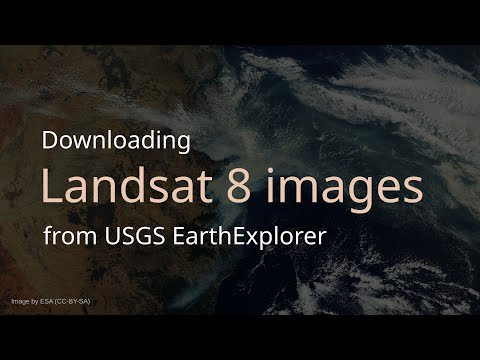

In [2]:
IPython.display.YouTubeVideo(id="Wn_G4fvitV8", width=640, height=360)

----

## Loading the data

Instead of manually loading the data for each band of each scene, let's make a function that reads in the bands we want for a particular scene.

This function needs to:

1. Find all of the `.TIF` files in the folder provided.
1. Match the file name to a band name (e.g., `"red"`).
1. Load the files corresponding to the bands that we specify.
1. Convert them from digitized values to reflectance and surface temperature.
1. Optionally crop the bands to a given pixel interval to avoid loading the full data all the time and crashing our computers.

That's a lot to ask so we'll split some of the tasks into other functions. This splitting has several advantages:

* It makes functions easier to understand since they are smaller.
* Functionality can be tested individually. For example, in this case we can check that the band name identification from the file name works without loading any data.
* Smaller functions can be reused later for other purposes. For example, our rescaling function can be used in data we loaded manually as well.

> 💡 **Tip:** When building these functions, I started with the `load_scene` function and then split off code from it into the other functions as I went along. That's often the best way of doing this. It can be very hard to plan all of these functions in your head before actually writing the code. Remember that software development is a process of continuous refinement. **No one writes perfect code from scratch**. We all start with a rough draft and iterate to make it better.

In [3]:
def load_scene(path, bands, crop=None):
    """
    Load the specified bands from a Landsat 8 scene.
    
    Assumes that the file names follow the convention from the 
    EarthExplorer website. All bands must be contained in the 
    same folder and only bands from a single scene should be in
    that folder.
    
    The data are rescaled to surface reflectance or temperature
    (depending on the band). Digitized values of 0 are converted
    to NaNs.
    
    Parameters
    ----------
    path : str
        The path to the folder containing the .TIF files
    bands : list
        List of band names to load. Valid band names are:
        ["blue", "green", "red", "nir", "swir1", "swir2", "thermal"].
    crop : list or None
        If not None, will crop the scene to the given pixel intervals.
        Should be a list with the min and max row and column values,
        in this order.
        
    Returns
    -------
    scene : dict
        A dictionary with the band names as keys and the band images
        as values.
    """
    # We'll store the scene in a dictionary with keys equal to the
    # band names and values as the actual data
    scene = {}
    # Make a Path object and use its "glob" method to find files matching
    # a pattern. This returns a list of all files in the path that end
    # in ".TIF". The * means "any character in any amount".
    tifs_in_path = Path(path).glob("*.TIF")
    for tif_file in tifs_in_path:
        band = band_from_file_name(tif_file)
        # Only load the bands we want
        if band in bands:           
            # Load the digitized image
            digitized_image = skimage.io.imread(tif_file)
            if crop is not None:
                digitized_image = digitized_image[crop[0]:crop[1], crop[2]:crop[3]]
            # Rescale the bands to surface temperature and reflectance           
            rescaled_image = rescale_digitized_band(digitized_image, band)
            # Pixels with zero uint16 values are missing values so mark them as NaN
            rescaled_image[digitized_image == 0] = np.nan
            # Add the rescaled image to our scene dictionary
            scene[band] = rescaled_image
    return scene


def band_from_file_name(path):
    """
    Get the band name given a Landsat8 .TIF file name.
    
    The band number is at the end of the file name ("_B1.TIF").
    
    Parameters
    ----------
    path : pathlib.Path
        A Path object with the path to the TIF file.
        
    Returns
    -------
    name : str
        The name of the band.
    """
    # Path objects have a "stem" attribute that is the file name
    # without extension and the containing folders
    file_name = path.stem
    # Split into part at the _ characters
    file_name_parts = file_name.split("_")
    # The last part if the B1, B2, etc
    band_part_of_name = file_name_parts[-1]
    # Slice the string to remove the B and convert the number to an int
    band_number = int(band_part_of_name[1:])
    # Match the number to the name using a dictionary
    band_names = {2: "blue", 3: "green", 4: "red", 5: "nir", 6: "swir1", 7: "swir2", 10: "thermal"}
    band = band_names[band_number]
    return band
    

def rescale_digitized_band(image, band_name):
    """
    Rescale a digitized image to surface temperature/reflectance.
    
    The conversion factors are taken from the Landsat8 Collection 2
    Level 2 product metadata. 
    
    Parameters
    ----------
    image : 2D array
        The digitized ("uint16") image.
    band_name : str
        Name of the band. Used to see if we want reflectance or 
        temperature.
        
    Returns
    -------
    rescaled_image : 2D array
        The rescaled image as a float32 array (to save memory).
    """    
    # Set the correct factors for the band
    if band_name == "thermal":
        multiplicative_factor = 0.00341802
        additive_factor = 149.0
    else:
        multiplicative_factor = 2.75e-05
        additive_factor = -0.2
    # Rescale the image. Convert the digital image to a float32 array first.
    # If we don't do this, numpy will convert to a float64 array when we
    # do the multiplication, which requires twice the memory. Since scenes
    # can get very large and 32 bits is more than enough precision, do 
    # this conversion explicitly to save memory.
    rescaled_image = image.astype("float32") * multiplicative_factor + additive_factor
    return rescaled_image

> 💡 **Tip:** Try running the `band_from_file_name` and `rescale_digitized_band` functions separately to check that they work. To do this, you'll need to manually set their inputs. For example, `band_from_file_name(Path("LC08_L2SP_017051_20151205_20200908_02_T1_SR_B2.TIF"))`.

Now that we have our `load_scene` function, let's use to load the red, green, and blue bands of the November scene. We'll limit to these 3 bands only because we're loading the full scene (which can be large) and our target (the Momotombo volcano) is small. With the 3 bands, we can make an RBG composite and try to find the cropping limits that would isolate the volcano. We can then load all the other bands and the December scene cropping to the volcano only. 

> ⚠️ **WARNING:** Trying to load all of the bands of multiple full scenes has a **high chance of crashing your computer**. For example, loading all the bands of a **single scene** with the code above requires **~2 Gb of RAM**. That's why I recommend loading only the RGB bands to figure out the cropping range first and then cropping all scenes to the relevant area.




In [4]:
momotombo_nov_full = load_scene(
    "momotombo/LC08_L2SP_017051_20151103_20200908_02_T1/", 
    bands=["blue", "green", "red"],
)
momotombo_nov_full

{'green': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 'red': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 'blue': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)}

Let's plot one of the bands to see what we've got.

Text(0, 0.5, 'Northing (pixels)')

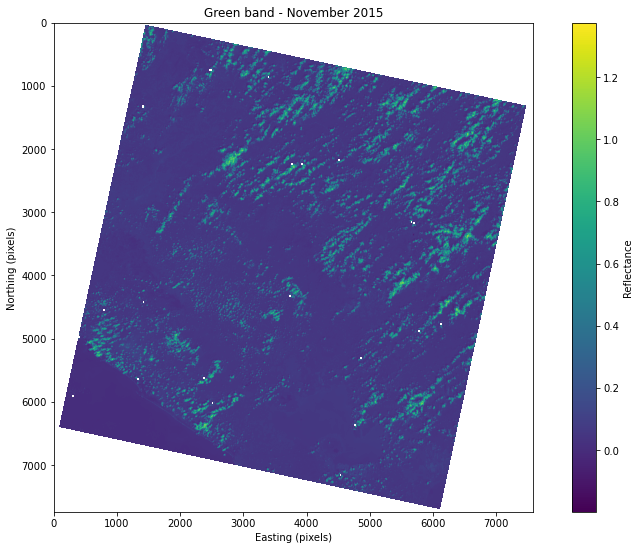

In [12]:
plt.figure(figsize=(14, 9))
plt.imshow(momotombo_nov_full["green"])
plt.colorbar(label="Reflectance")
plt.title("Green band - November 2015")
plt.xlabel("Easting (pixels)")
plt.ylabel("Northing (pixels)")

It's hard to see anything in that scene, let alone find the volcano. An RGB composite is what we really need. So let's make a function for this! In fact, we can make a generic function that makes arbitrary composites (given the bands that should go in red, green, and blue channels).

Our function will need to:

* Take a scene dictionary and the bands that should go in to the red, green, and blue channels as input.
* Create the empty "uint8" array that matplotlib wants.
* Convert the given bands to "uint8".
* Set the given bands from the scene to the red, green, and blue parts of the array.
* Apply contrast stretching through the `in_range` argument. This is actually required since our data have NaNs in them. It's also generally needed to make dark scenes easier to see.

In [6]:
def make_composite(scene, red, green, blue, in_range):
    """
    Create a composite with the given bands of a scene.
    
    Applies contrast stretching to each band with the given
    in_range. 
    
    Parameters
    ----------
    scene : dict
        Dictionary containing a Landsat8 scene.
    red, green, blue : str
        The names of the bands from the scene that will go into
        the red, green, and blue channels of the composite.
    in_range : tuple
        Minimum and maximum reflectance values used to stretch
        the contrast of the bands.
        
    Returns
    -------
    composite : 3D array
        A uint8 array that can be used with plt.imshow.
    """
    # Get the number of rows and columns of the scene so 
    # we can create the composite array
    nrows, ncols = scene[red].shape
    # Make the empty 3D array to hold the composite
    composite = np.empty((nrows, ncols, 3), dtype="uint8")
    # This list has the name of the bands from scene that
    # should go in each channel.
    bands = [red, green, blue]
    # Loop over each of the red, green, and blue channels.
    # Using enumerate gives us the index of the channel in the
    # 3D array along with the band name from the bands list.
    for i, band in enumerate(bands):
        # Assign the band to the composite channel.
        # Also apply the contrast stretching in the same operation.
        composite[:, :, i] = skimage.exposure.rescale_intensity(
            scene[band],
            in_range=in_range,
            out_range="uint8",
        )
    return composite

Make the RBG composite from the full scene and add it to the scene dictionary. 

> 💡 **Tip:** Doing this instead of putting it in a separate variable means that we don't have to come up with many variable names. That's why dictionaries are awesome!

We'll set the range for contrast stretching by trial and error here but you could also plot the histogram of all bands to see what is an appropriate range.

In [17]:
momotombo_nov_full["rgb"] = make_composite(
    momotombo_nov_full, 
    red="red", 
    green="green", 
    blue="blue", 
    in_range=(0, 0.15),
)

Text(0, 0.5, 'Northing (pixels)')

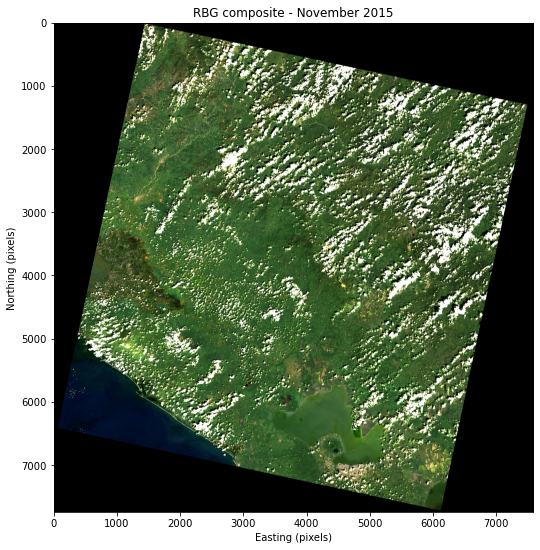

In [18]:
plt.figure(figsize=(14, 9))
plt.imshow(momotombo_nov_full["rgb"])
plt.title("RBG composite - November 2015")
plt.xlabel("Easting (pixels)")
plt.ylabel("Northing (pixels)")

The volcano is that tiny spec of black next to the lake at around pixel 3500 East and 6000 North. Now we can load the full scene but cropping to the volcano only.

In [9]:
scene = load_scene(
    "momotombo/LC08_L2SP_017051_20151103_20200908_02_T1/", 
    bands=["blue", "green", "red", "nir", "swir1", "swir2", "thermal"],
    crop=[5850, 6100, 3500, 3800],
)

In [10]:
scene["rgb"] = make_composite(scene, red="red", green="green", blue="blue", in_range=(0, 0.15))

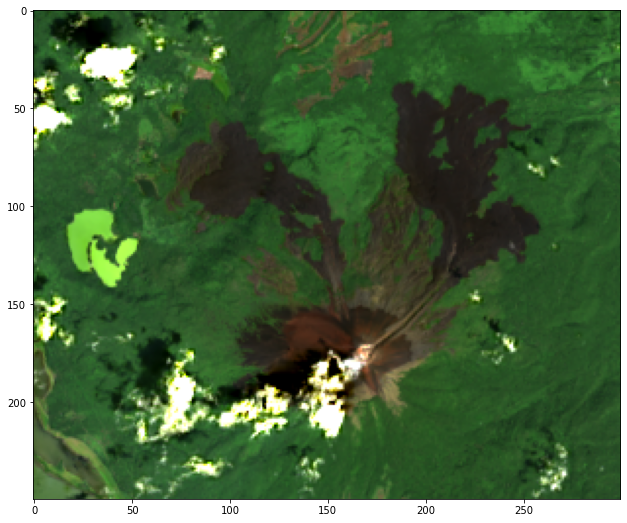

In [11]:
plt.figure(figsize=(14, 9))
plt.imshow(scene["rgb"])

In [12]:
scene = load_scene(
    "momotombo/LC08_L2SP_017051_20151205_20200908_02_T1/", 
    bands=["blue", "green", "red", "nir", "swir1", "swir2", "thermal"],
    crop=[5850, 6100, 3500, 3800],
)

In [13]:
scene["rgb"] = make_composite(scene, red="red", green="green", blue="blue", in_range=(0, 0.15))

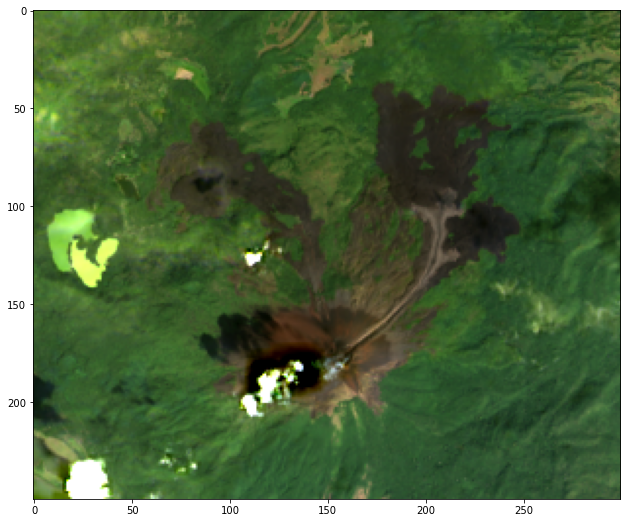

In [28]:
plt.figure(figsize=(14, 9))
plt.imshow(scene["rgb"])

In [16]:
scene["cir"] = make_composite(scene, red="nir", green="red", blue="green", in_range=(0, 0.6))

In [17]:
scene["cir"] = make_composite(scene, red="swir2", green="swir1", blue="red", in_range=(0, 0.5))

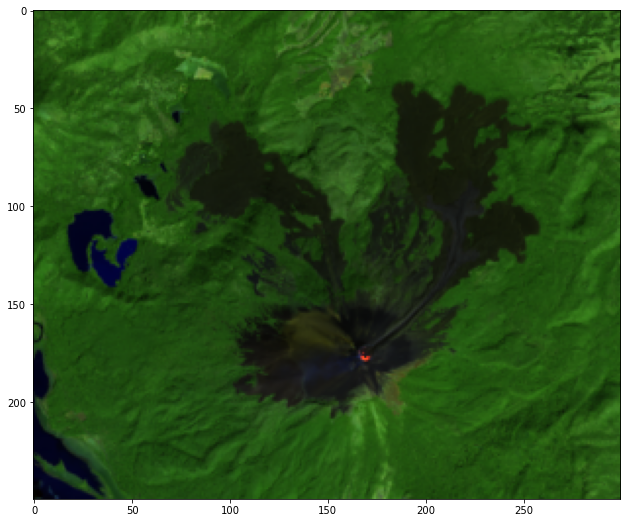

In [18]:
plt.figure(figsize=(14, 9))
plt.imshow(scene["cir"])

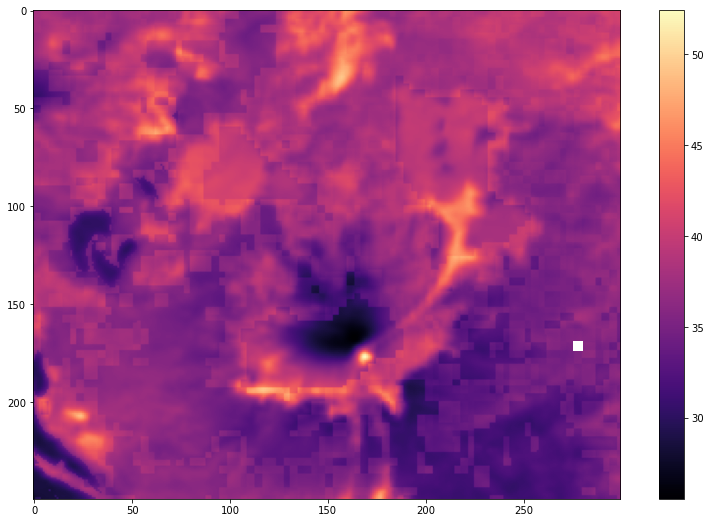

In [19]:
plt.figure(figsize=(14, 9))
plt.imshow(scene["thermal"], cmap="magma")
plt.colorbar()

In [20]:
def make_ndvi(scene):
    result = (scene["nir"] - scene["red"]) / (scene["nir"] + scene["red"])
    return result

In [21]:
scene["ndvi"] = make_ndvi(scene)

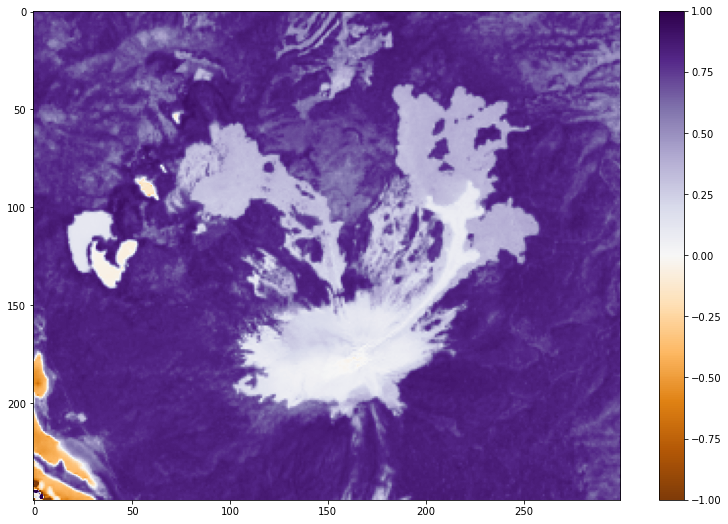

In [22]:
plt.figure(figsize=(14, 9))
plt.imshow(scene["ndvi"], vmin=-1, vmax=1, cmap="PuOr")
plt.colorbar()